# 1. k-NN clustering method

In this project, we will code the k-Nearest Neighbors clustering method from scratch

## 1.1. Theory

The framework of this project is a sample of n points in $\mathbb R^d$ and we want to label those points in $k$ groups : the clusters.  
How ?  
We will first select $k$ random points in the sample that we call centers. All the points of the sample will be affected to a center the following way:  
$Label(X_n)=\arg\min_{0\leq j \leq k-1}\|X_n-C_j\|_{L^2}^{\mathbb R^d}$ with $X_n$ the $n^{th}$ point and $C_j$ the $j^{th}$ center.  
We then obtain a label for each point and can compute again the centers : $\forall 0\leq j \leq k-1, C_j = avg(X_n)$ such that $Label(X_n)=j$.  
We repeat this operation until the centers have stabilized.  
Once we have our first classification, we have a strong dependance on the choice of the first $k$ random points, to weaken this dependance, we will repeat the same operation few times and select the classification that has the smallest intra-cluster variance (we compress the clusters as much as possible).  

## 1.2. Computation

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1.2.1. Creation of a sample in $\mathbb R^d$

In [351]:
def sample(n, mu, sigma):
    '''
    Parameters:
    
    n: int, number of points
    mu: numpy array, mean vector of size (d,k)
    sigma: numpy array, standard deviation vector of size (1,k)
    
    Output:

    M: numpy array, matrix of size (d,n) containing the points
    '''
    d = np.shape(mu)[0]
    k = np.shape(mu)[1]

    if k != np.shape(sigma)[1]:
        raise ValueError(f"Dimension mismatch: k = {k}, but sigma has {np.shape(sigma)[1]} columns.")

    points = []
    for j in range(k):
        mean_vector = mu[:,j].reshape(d,1)
        std = sigma[0,j]
        bias_vector = std*np.random.normal(loc=0, scale=1, size=(d,n//k))
        points.append(mean_vector + bias_vector)
    M = np.hstack(points)
    M = M[:,np.random.permutation(M.shape[1])]

    return M
        

Test in $\mathbb R^2$ to see if the code is runnning properly

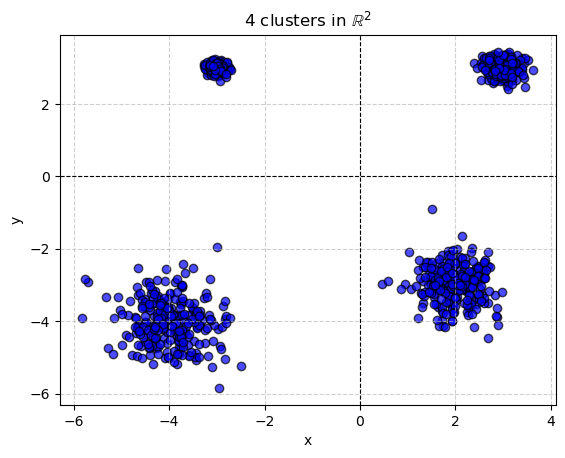

In [353]:
n = 1000
mu = np.array([[-3,-4,3,2],[3,-4,3,-3]])
sigma = np.array([[0.1, 0.6, 0.2, 0.5]])
M = sample(n, mu, sigma)

plt.scatter(M[0,:],M[1,:],c='blue', alpha=0.7, edgecolor='k')
plt.title(rf"{np.shape(mu)[1]} clusters in $\mathbb{{R}}^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 1.2.2. Computation of the kNN algorithm

In [355]:
def knn(M,k):
    '''
    Parameters:
    
    M: numpy array, matrix of size (d,n) of the points
    k: int, the number of cluster

    Output:
    N: numpy array, matrix of size (d+1,n) same as M for the first d lines but the last lines contains the labels
    '''

    d = np.shape(M)[0]
    n = np.shape(M)[1]

    clusters = [] #List that will stock all the 100 classification and its intra-cluster variance
    for a in range(5):
        #Selection of k random points in M
        previous_centers = np.zeros((d,k))
        new_centers = M[:,np.random.choice(n, size=k, replace=False)]
        while not np.array_equal(previous_centers, new_centers) :
            #Computation for each point of the shortest distance to the centers
            distances = np.zeros((k,n))
            labels = []
            for j in range(n):
                for i in range(k):
                    distances[i,j] = np.linalg.norm(new_centers[:,i] - M[:,j])
                label = np.argmin(distances[:,j])
                labels.append(label)
            N = np.vstack((M,labels))
            previous_centers = new_centers
            new_centers = np.array([np.mean(N[:d,N[-1,:]== m],axis = 1) for m in range(k)]).transpose()
        intraClusterStd = np.sum([np.var(N[:d, N[-1, :] == m], axis = 1) for m in range(k)])
        clusters.append((N, intraClusterStd))
    return clusters[min(range(len(clusters)), key=lambda i: clusters[i][1])][0] # We return the classification that led to the smallest intra-cluster variance
    
    

Test in $\mathbb R^2$

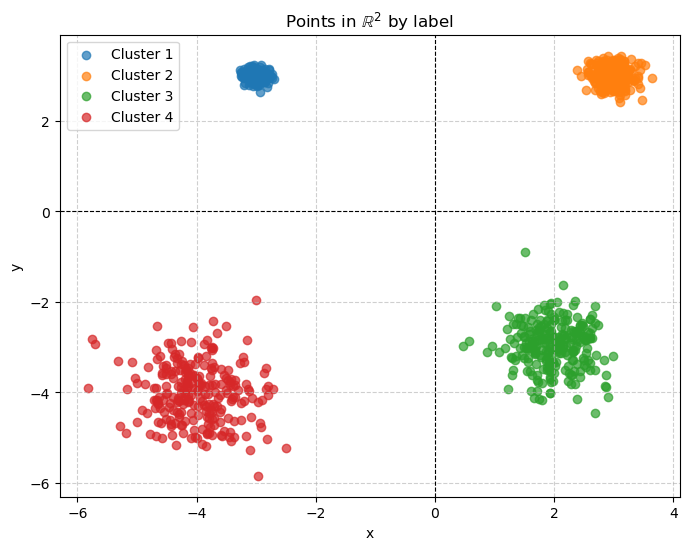

In [357]:
N = knn(M,4)
x = N[0,:]
y = N[1,:]
labels = N[2,:]
plt.figure(figsize=(8, 6))
for label in np.unique(labels):  # Pour chaque label unique
    plt.scatter(x[labels == label], y[labels == label], label=f"Cluster {int(label)+1}", alpha=0.7)

# Personnalisation du graphique
plt.title(r"Points in $\mathbb{R}^2$ by label")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 1.2.3. Selection of k

In practice we do not know how many clusters we need to consider (ie we do not know $k$), we need to consider the intra-cluster varaince "waterfall" and look for an elbow

In [360]:
def waterfall(M):
    '''
    Parameters:
    
    M: numpy array, matrix of size (d,n) of the points

    Output:
    
    Plots the intra-cluster variance waterfall to help us in the selection of k
    '''
    d = np.shape(M)[0]
    intraClusterStd = []
    for k in tqdm(range(1,8)):
        N = knn(M,k)
        intraClusterStd.append(np.sum([np.var(N[:d, N[-1, :] == m], axis = 1) for m in range(k)]))
        
    plt.plot([k for k in range(1,8)], intraClusterStd)
    plt.title(r"Intra-Cluster Variance Waterfall")
    plt.xlabel("k")
    plt.ylabel("Intra-Cluster Variance")
    plt.show()

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.49it/s]


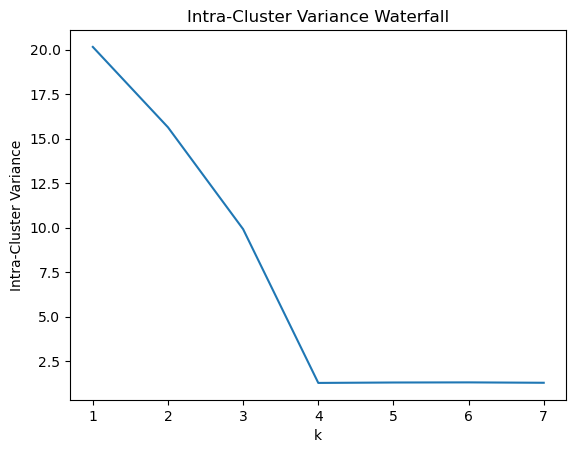

In [361]:
waterfall(M)

We can see that there is a big elbow for $k=4$ we can conclude that taking $4$ clusters is adapted